In [1]:
import math
import warnings
from random import choice

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from helper import LogScaler, StockHelper
from preproc import get_stock_data


In [2]:
warnings.filterwarnings("ignore")


In [3]:
stocks = StockHelper.get_stock_symbol_mapping()
stock, symbol = choice(list(stocks.items()))


In [4]:
df = get_stock_data(symbol, days=300)



In [5]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()
    plt.plot(timeseries, color="black", label="Original")
    plt.plot(rolmean, color="limegreen", label="Rolling Mean")
    plt.plot(rolstd, color="red", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries, autolag="AIC")
    output = dict(zip(["Test Statistics", "p-value", "# of lags used", "# of obs used"], adft[0:4]))

    for key, values in adft[4].items():
        output[f"critical value ({key})"] = values

    print(output, "\n")

    if output["p-value"] > 0.05:
        print("The data is not stationary since it fails to reject the null hypothesis")

    else:
        print("The data is stationary since reject the null hypothesis")



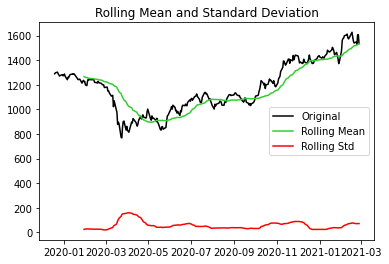

Results of dickey fuller test
{'Test Statistics': -0.4529815777578076, 'p-value': 0.9008698824970041, '# of lags used': 6, '# of obs used': 293, 'critical value (1%)': -3.452867117291862, 'critical value (5%)': -2.8714554160827745, 'critical value (10%)': -2.5720532321867466} 

The data is not stationary since it fails to reject the null hypothesis


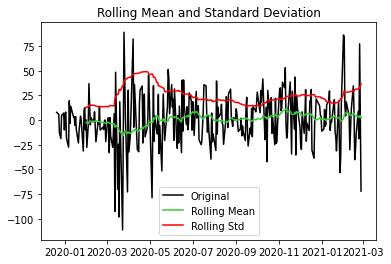

Results of dickey fuller test
{'Test Statistics': -7.354330602459581, 'p-value': 9.87082520251754e-11, '# of lags used': 5, '# of obs used': 293, 'critical value (1%)': -3.452867117291862, 'critical value (5%)': -2.8714554160827745, 'critical value (10%)': -2.5720532321867466} 

The data is stationary since reject the null hypothesis


In [6]:
df["close_diff"] = df["close_price"] - df["close_price"].shift(1)
# df['close_diff'].dropna().plot()
test_stationarity(df["close_price"])
test_stationarity(df["close_diff"].dropna())


<Figure size 432x288 with 0 Axes>

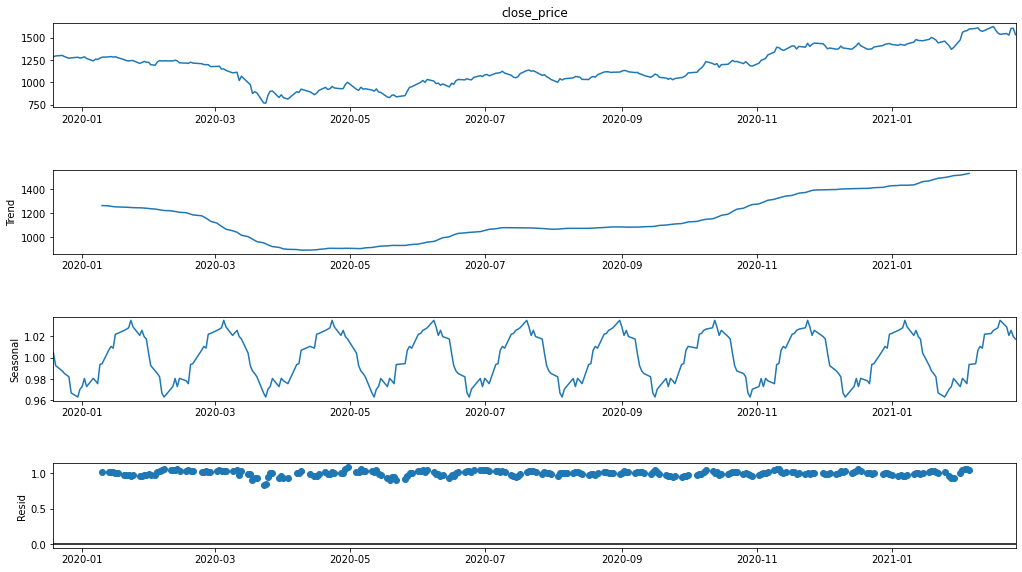

In [7]:
result = seasonal_decompose(df["close_price"], model="multiplicative", freq=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)


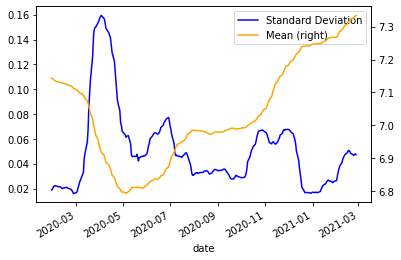

In [8]:
df_log = LogScaler(df["close_price"]).transform()
moving_avg = df_log.rolling(30).mean()
std_dev = df_log.rolling(30).std()
std_dev.plot(c="blue", label="Standard Deviation", legend=True)
moving_avg.plot(c="orange", secondary_y=True, label="Mean", legend=True)
plt.show()


In [9]:
train_size = 0.9

close = df["close_price"]
train_size = int(len(close) * train_size)
train_data, test_data = close[:train_size], close[train_size:]

print(train_data.tail(), test_data.head(), sep="\n")


date
2021-01-08    1431.65
2021-01-11    1451.45
2021-01-12    1481.00
2021-01-13    1470.65
2021-01-14    1468.75
Name: close_price, dtype: float64
date
2021-01-15    1466.65
2021-01-18    1483.10
2021-01-19    1503.85
2021-01-20    1492.00
2021-01-21    1474.80
Name: close_price, dtype: float64


In [10]:
train_data = LogScaler(train_data).transform()
test_data = LogScaler(test_data).transform()


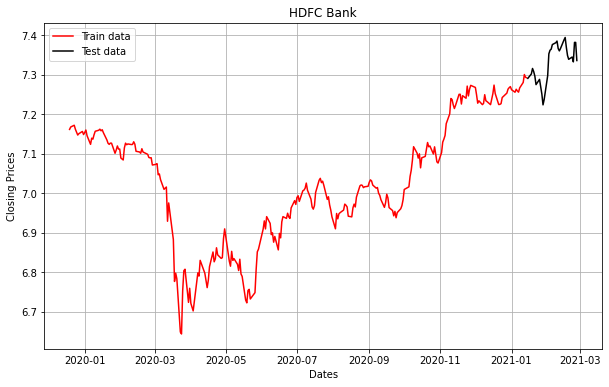

In [11]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.title(stock)
plt.xlabel("Dates")
plt.ylabel("Closing Prices")
plt.plot(train_data, "red", label="Train data")
plt.plot(test_data, "black", label="Test data")
plt.legend()


In [12]:
model = auto_arima(
    train_data,
    test="adf",
    start_p=0,
    start_q=0,
    d=None,
    max_p=5,
    max_d=5,
    max_q=5,
    start_P=0,
    start_Q=0,
    D=1,
    max_P=5,
    max_D=5,
    max_Q=5,
    m=12,
    seasonal=True,
    error_action="ignore",
    trace=True,
    supress_warnings=True,
    stepwise=True,
    n_fits=50,
)
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-498.236, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-1049.053, Time=2.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-499.306, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-999.925, Time=0.23 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-1074.334, Time=6.99 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=-1081.794, Time=19.10 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=-1083.420, Time=33.88 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=-1085.442, Time=31.76 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=-1100.385, Time=34.84 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=-1083.967, Time=39.75 sec
 ARIMA(1,0,0)(5,1,2)[12] intercept   : AIC=inf, Time=40.70 sec
 ARIMA(1,0,0)(4,1,2)[12] intercept   : AIC=inf, Time=44.36 sec
 ARIMA(0,0,0)(5,1,1)[12] intercept   : AIC=-512.292, Time=21.66 sec
 ARIMA(2,0,0)(5,1,1

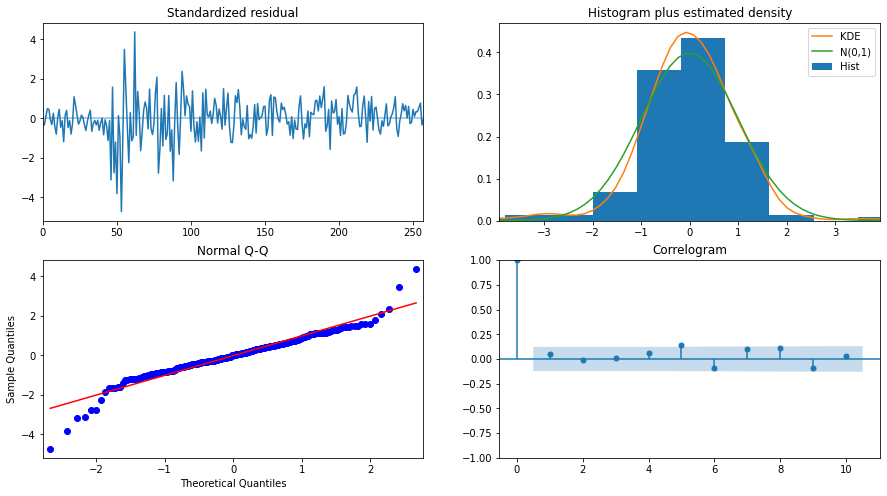

In [13]:
model.plot_diagnostics(figsize=(15, 8))
plt.show()


In [14]:
prediction = pd.Series(
    model.predict(len(test_data)),
    name="predicted_price",
    index=test_data.index,
)


In [15]:
test_data = LogScaler(test_data).inverse_transform()
train_data = LogScaler(train_data).inverse_transform()
prediction = LogScaler(prediction).inverse_transform()
dff = pd.DataFrame({"actual": test_data, "predicted": prediction})
dff


,actual,predicted
date,,
2021-01-15,1466.65,1469.309222
2021-01-18,1483.10,1463.540487
2021-01-19,1503.85,1460.353418
2021-01-20,1492.00,1462.386684
2021-01-21,1474.80,1466.568181
2021-01-22,1443.55,1455.399814
2021-01-25,1462.85,1440.648901
2021-01-27,1409.60,1447.164570
2021-01-28,1371.45,1439.412863


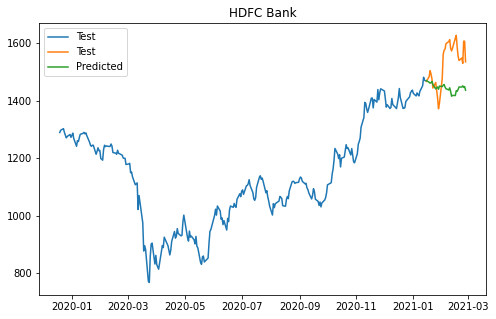

In [16]:
plt.figure(figsize=(8, 5))
plt.title(stock)
plt.plot(train_data, label="Test")
plt.plot(test_data, label="Test")
plt.plot(prediction, label="Predicted")
plt.legend(loc="upper left")
plt.show()


In [18]:
mae_score = mean_absolute_error(test_data, prediction)
print(f"MAE: {mae_score}")
rmse_score = math.sqrt(mean_squared_error(test_data, prediction))
print(f"RMSE: {rmse_score}")
normalised_rmse_score = math.sqrt(mean_squared_error(test_data, prediction)) / (
    test_data.max() - test_data.min()
)
print(f"NRMSE: {normalised_rmse_score}")
mape_score = np.mean(np.abs(prediction - test_data) / np.abs(test_data))
print(f"MAPE: {mape_score}")


MAE: 100.14614660527812
RMSE: 117.1751476321908
NRMSE: 0.4591502650164232
MAPE: 0.06390101074019872
